In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import glob
from astropy.table import Table
from astropy.table import join
from astropy.table import vstack
import pdb

# Creating Contrast Curves

Using NIRCAM data simulated by the Space Telescope Science Institute, we'd like to estimate the contrast needed by a given planet at different separations from its host star in order for it to be detectable by the James Webb Space Telescope. This notebook performs an analysis of contrast in starlight-subtracted images in order to generate contrast curves for the visualization of this information.
The first step in this process is thus utilzing the pyKLIP algorithm to remove starlight, then measuring the contrast in the image at varying distances. However, this PSF subtraction can result in the distortion of planet spectrum, and an oversubtraction of flux from the image as a whole. Thereofore, we also measure the algortithm throughput as a function of planet sepration.

### Loading the dataset

This loads loads in our simulated JWST data, specifying the roll angle (10 arcseconds is the maximum roll angle) as well as the center as the image and the inner working angle. It combines images from both roll angles (0 and 10 arcseconds) to create a full sequence of images.

In [2]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Run Klip

Use the pyklip algortihm on the dataset in order to remove starlight from the images. Using KLIP-ADI reductions, we will break the image into 9 concentric annuli, and each annuli into 4 azimuthal sectors.

In [3]:
parallelized.klip_dataset(dataset, outputdir="./", fileprefix="pyklip-f300m-ADI-k50a9s4m1", annuli=9, 
                          subsections=4, numbasis=[1,5,10,20,50], mode="ADI", movement=1)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 12, 1, 101, 101)


/Users/jeaadams/.local/share/virtualenvs/JWST-ERS-Pipeline-aupfB8Z0/lib/python3.7/site-packages/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)


### Mask Any Real Planets in Image

There are two "real" planets already in this dataset, but we don't want to include them in our noise estimation. Their positions are at (41,54) and (43,70) respectively. We will therefore mask these this positions with nans before calculating the contrast in our images. We used 5 KL modes to KLIP our data, but to create the contrast curve we only need 1 frame. We'll arbitrarily chose the KL mode with an index of 2 to accomplish this. 

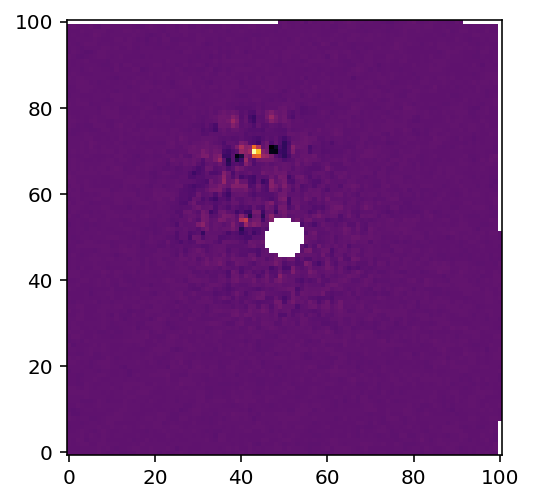

In [4]:
#Read in the KLIP-ed dataset
with fits.open("pyklip-f300m-ADI-k50a9s4m1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data
    adi_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

    
#Plot the KL10 Cube (index of 2)
plt.figure() 
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

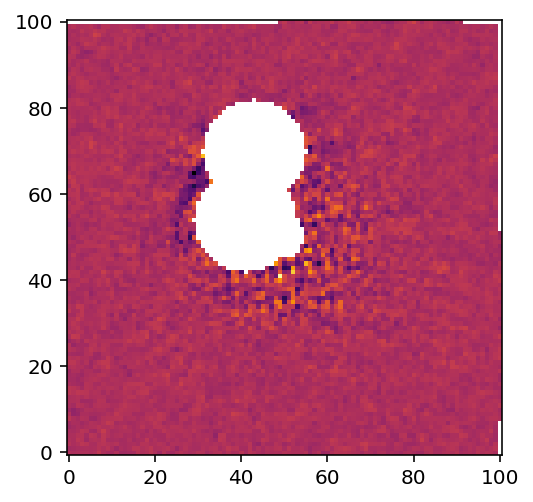

In [5]:
#Mask the 1st planet
planet1_peak_x = 41 
planet1_peak_y = 54

#Create an array with the indices are that of KL mode frame with index 2
ydat, xdat = np.indices(adi_cube[2].shape)

#Set the FWHM of the PSF
psf_fwhm = 6

#Calculate the distance around the planet to be masked
distance_from_planet1 = np.sqrt((xdat - planet1_peak_x)**2 + (ydat - planet1_peak_y)**2)

#Mask
adi_cube[2][np.where(distance_from_planet1 <= 2*psf_fwhm)] = np.nan

#fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)
#Use pyklip.fakes to gaussfit2d and centroid on tiny planets
#Mask the second planet
planet2_peak_x = 43
planet2_peak_y = 70
distance_from_planet2 = np.sqrt((xdat - planet2_peak_x)**2 + (ydat - planet2_peak_y)**2)
adi_cube[2][np.where(distance_from_planet2 <= 2*psf_fwhm)] = np.nan

#plot the new masked data
plt.figure()
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

### Measure the Contrast

Using the pyKLIP function meas_contrast, we can compute the 5 $\sigma$ noise at each separation in our image. For this function, we again need to specify our planet's FWHM as well as our outer working angle and the center of our input frame. 

In [6]:
OWA = 65 #Setting this to be distance between star and outer edge of image

#Measuring the contrast in the image
contrast_seps, contrast = pyklip.klip.meas_contrast(dat = adi_cube[2], 
                                                     iwa = dataset.IWA, 
                                                     owa = OWA, 
                                                     resolution = (psf_fwhm), 
                                                     center = adi_centers,
                                                     low_pass_filter = False)

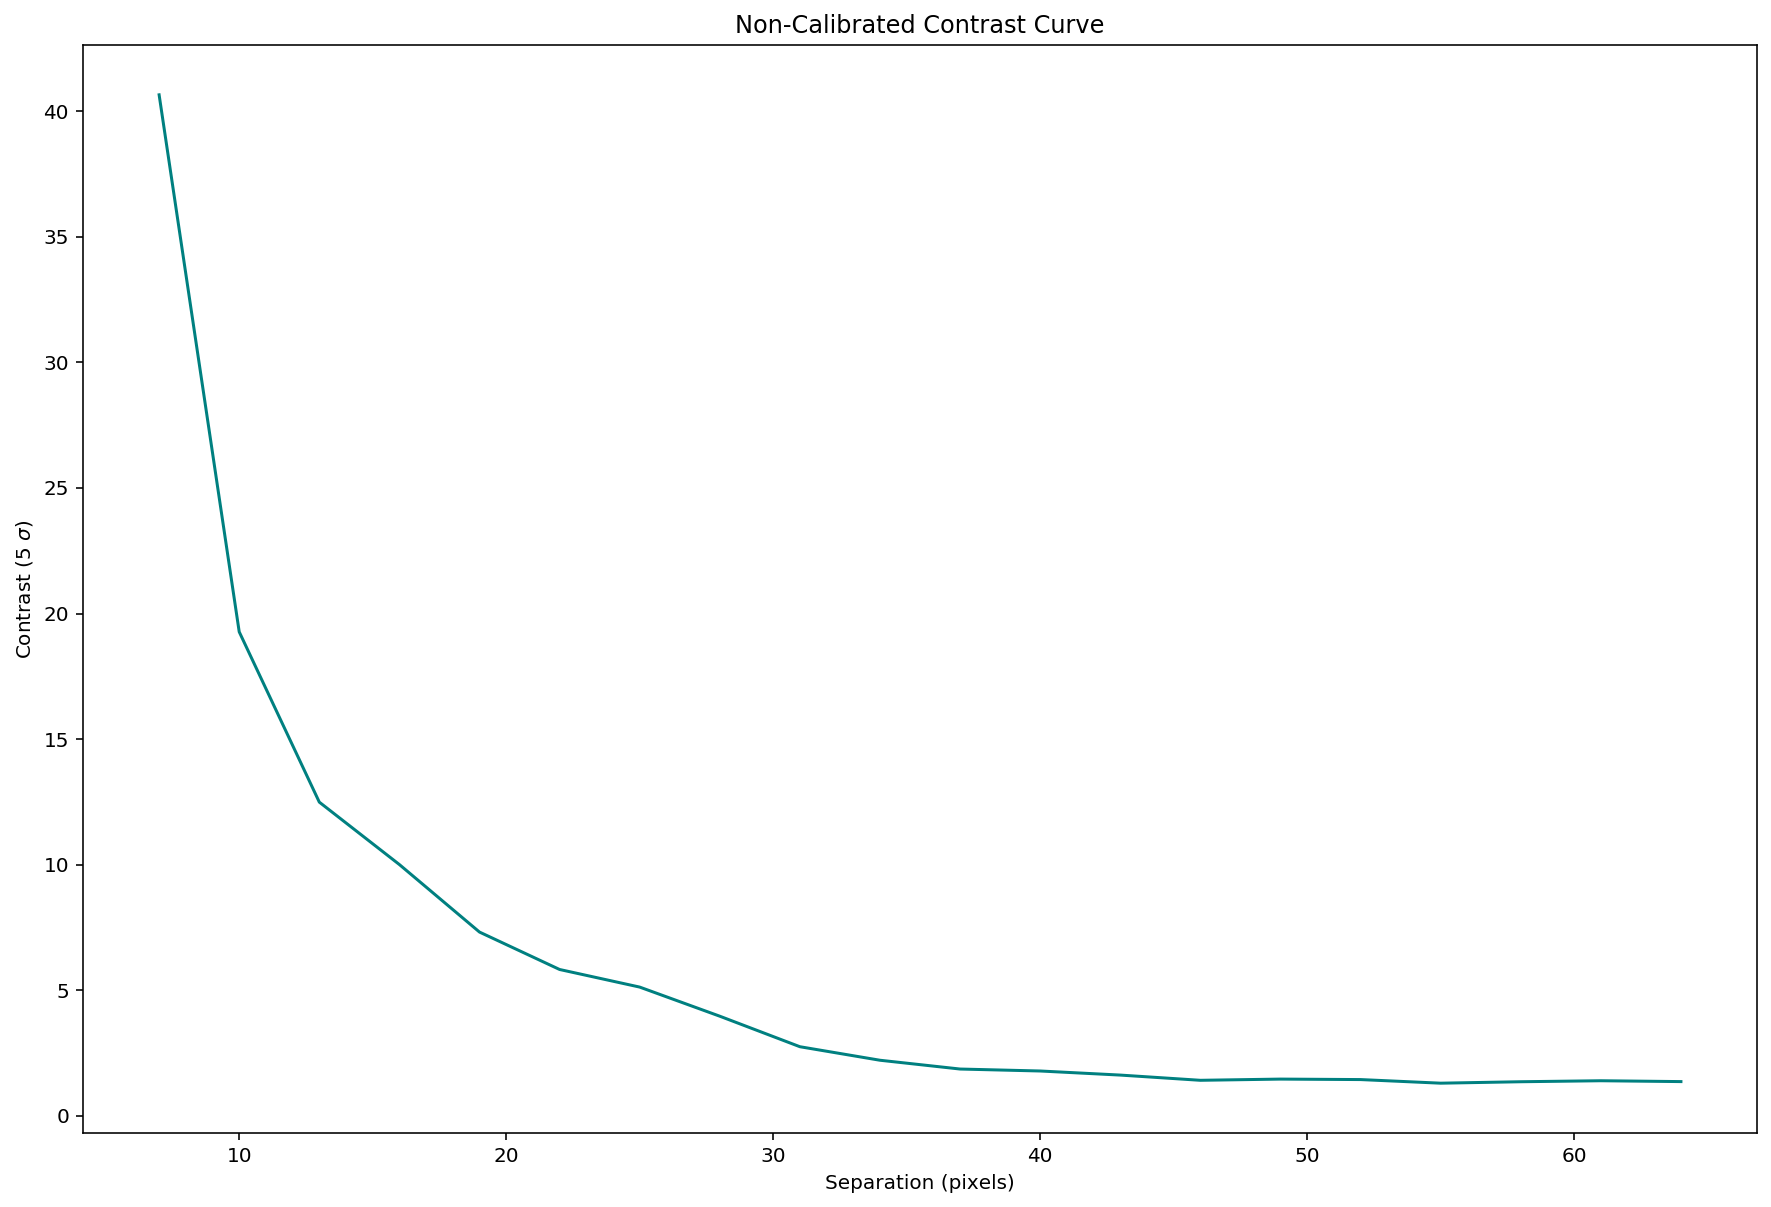

In [7]:
#Plot contrast curve!
plt.figure(figsize = (15,10))
plt.plot(contrast_seps, contrast, color = "teal")
plt.xlabel("Separation (pixels)")
plt.ylabel("Contrast (5 $\sigma$)")
plt.title("Non-Calibrated Contrast Curve")
plt.rcParams.update({'font.size': 22})
plt.savefig("contrast_adi2.png", dpic = 500)

## Computing throughput

Now that we've created our contrast curve, we can calculate the throughput of our KLIP reduced images. In order to optimize this calculation, we need to inject multiple fake planets at varying separations and postion angles to get a feel for how throughput changes across the image.

### The Fake Planets to be Injected:

The injected fake planets will be scaled down versions of the unocculted PSF. The following code simply crops and centers this unocculted psf to prepare it for injection

In [8]:
# read in unocculted PSF
with fits.open("old_simulated_data/NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    psf_head = hdulist[0].header
    
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])

### Generating a dataset
First, we need to generate data of the science target taken at two telescope roll angles. 

In [9]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)//2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Injecting the fake planets

Now that we have our data and have prepare our fake planet to be injected, we can choose how many we'd like to put into our dataset, what we want their relative fluxes to be, and their separations from the planet. For now, we'll inject four planets into a single dataset.

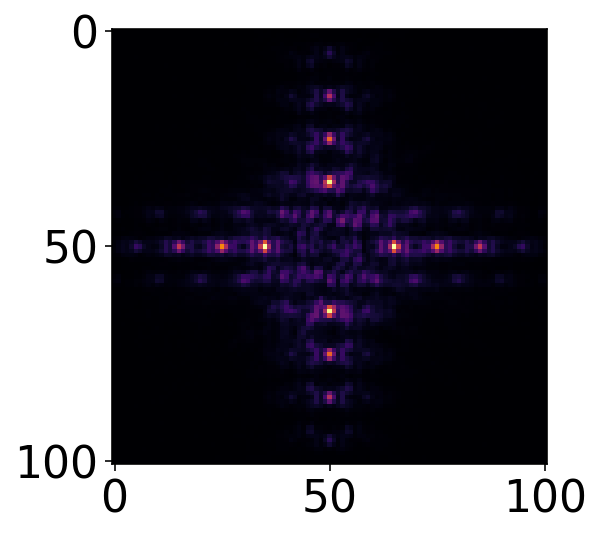

In [13]:
#Let's choose our contrasts so that the planets get fainter as we go further from the star
psf_stamp_input = np.array([psf_stamp for j in range(12)])
input_contrasts = [1e-3, 7e-4, 5e-4]
planet_seps = [15, 25, 35]
pa = [0, 90, 180, 270]

#Now injecting the fake planets in a spiral:
for input_contrast, planet_sep in zip(input_contrasts, planet_seps):
    planet_fluxes = psf_stamp_input*input_contrast
    
    for pas in pa:
        fakes.inject_planet(frames = dataset.input, 
                            centers=dataset.centers, 
                            inputflux=planet_fluxes, 
                            astr_hdrs=dataset.wcs, 
                            radius=planet_sep,
                            pa = pas)

plt.imshow(dataset.input[0], interpolation="nearest", cmap="inferno")

### Run KLIP - Recover Planets

Now that we've injected our fake planets, we can check how well we were able to recover them by running KLIP. We'll only use 1 subsection and 1 annulus. 

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1
Closing threadpool
Derotating Images...
Writing Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks/contrastcurves
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 12, 1, 101, 101)


/Users/jeaadams/.local/share/virtualenvs/JWST-ERS-Pipeline-aupfB8Z0/lib/python3.7/site-packages/pyklip/klip.py:47: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=axis)


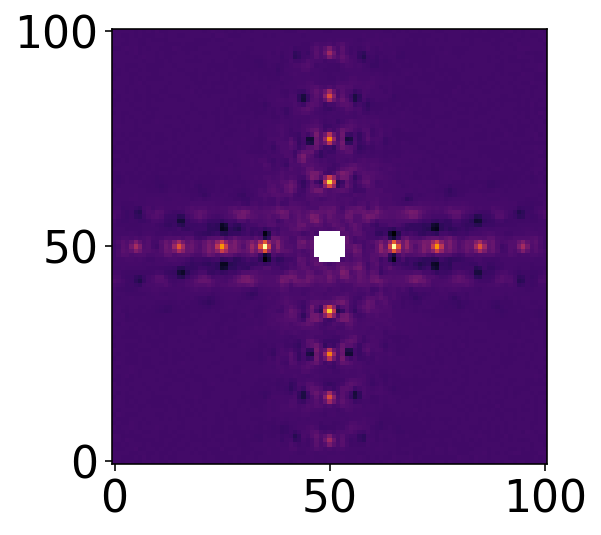

In [11]:
 #Set output directory
outputdir = 'contrastcurves'
fileprefix = 'FAKE_KLIP_ADI_A9K5S1M1'
numbasis = [1,5,10,20,50]


#Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset, 
                          outputdir=outputdir, 
                          fileprefix=fileprefix, 
                          algo = 'klip', 
                          annuli=1, 
                          subsections=1, 
                          movement=1, 
                          numbasis=numbasis, 
                          mode="ADI")

# Plot this reduced data cube. 
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S1M1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data
    
plt.figure()
# plot the KL10 Cube (index of 2)
plt.imshow(adi_cube[2], interpolation='nearest', cmap='inferno')
plt.gca().invert_yaxis()

### Recovering Flux Values

We can now visually inspect how well we were able to recover each injected planet, but if we want to quantify this algrorithm throughput, pyKLIP has a built in function "retrieve_planet_flux" so we can compare the retrieved flux to the input flux

In [12]:
#Obtain the centers of the output KLIP fits file
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S1M1-KLmodes-all.fits") as hdulist:
    cube = hdulist[0].data
    cube_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

#Create and empty list to store retrieved flux values
retrieved_fluxes = []

#Retrieve planet fluxes
for input_contrast, planet_sep in zip(input_contrasts, planet_seps):
    
    fake_planet_fluxes = []
                                      
    for pas in pa:
        fake_flux = fakes.retrieve_planet_flux(frames = cube[2], 
                                            centers = cube_centers,
                                            astr_hdrs = dataset.wcs[0], 
                                            sep = planet_sep,
                                            pa = pas)
        fake_planet_fluxes.append(fake_flux)

    retrieved_fluxes.append(fake_flux)

ValueError: operands could not be broadcast together with shapes (13,15) (15,15) 

## Inject fake planets 

 Therefore, we'll create a loop that injects 10 planets at a set list of separations, but changing the position angle or "thetas" each time. Each time it injects a new set of fake planets, it runs pyKLIP on the injected dataset, and then retrieves the fluxes of the fake planets from the KLIP-ed data to be output into a table.  
Since we're using a loop to inject fake planets in new locations each time, we also need to regenerate a new dataset each time. Here we'll generate 10 datasets.

In [ ]:
datasets = []
for dataset in range(10):
    
    #Import the dataset to be used
    filtername = "f300m"

    # read in roll 1
    with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
        roll1_cube = hdulist[0].data

    # read in roll 2
    with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
        roll2_cube = hdulist[0].data  

    # combine the two rows
    full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

    # two rolls are offset 10 degrees
    pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

    # for each image, the (x,y) center where the star is is just the center of the image
    centers = np.array([np.array(frame.shape)//2. for frame in full_seq])

    # give it some names, just in case we want to refer to them
    filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                          ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

    #Define dataset
    dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
    dataset.flipx = False
    datasets.append(dataset)

### Begin the loop:

1) Specify Values of thetas for planets to be injected at  
2) Specify input contrasts and planet separations  
3) Inject fake planets with  fakes.inject_planet  
4) Run KLIP on fake injected dataset  
5) Read in the KLIP-ed dataset  
6) Retrieved fluxes of injected planets with fakes.retrieve_planet_flux  
7) Append retrieved fluxes, planet separtions and contrasts to a list  

In [ ]:
# thetas = [0, 60, 210, 270]
# thetas_step_size = 75
# for i in range(len(datasets)):
#     thetas_values = [(x+thetas_step_size*i*np.ones(12))-dataset.PAs for x in thetas]

In [ ]:
# thetas_values

In [ ]:
# thetas = [0, 60, 210, 270]
# thetas_step_size = 75
# thetas_array = [(x+thetas_step_size*i*np.ones(12))-dataset.PAs for x in thetas]
# input_contrasts = [3e-3, 2e-3, 1e-3, 3e-3]
# planet_seps = [10,12, 15,20]    
# for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_array):
#         check_sep_x = planet_sep*np.cos(theta) 
#         check_sep_y = planet_sep*np.sin(theta)
#         dist = np.sqrt((check_sep_x - planet2_peak_x)**2 + (check_sep_y - planet2_peak_y)**2) 
#         if dist < 12:
#             continue

In [ ]:
#convert the x y of the real planets to pa (give an estimate)
#if the fakes planets sep pa is too close to real planets sep pa, don't inject it.

In [ ]:
def test_multiple_planets(input_contrasts, planet_seps, thetas, thetas_step_size):
    
    #put pa's in the arguments instead of arguments
    
    for dataset_num, dataset in enumerate(datasets):
        
        psf_stamp_input = np.array([psf_stamp for j in range(12)])
        thetas_array = [(x+thetas_step_size*dataset_num*np.ones(12))-dataset.PAs for x in thetas]
        
        start_over = False
        for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_array):
            #change theta to pa and add 90 degrees.
            check_sep_x = planet_sep*np.cos(pa[0]) 
            check_sep_y = planet_sep*np.sin(pa[0])
            
            dist_p1 = np.sqrt((check_sep_x - planet1_peak_x)**2 + (check_sep_y - planet1_peak_y)**2)
            dist_p2 = np.sqrt((check_sep_x - planet2_peak_x)**2 + (check_sep_y - planet2_peak_y)**2)
            
            if dist_p1 > 12 and dist_p2 > 12:
                planet_fluxes = psf_stamp_input*input_contrast


                fakes.inject_planet(frames = dataset.input, 
                                    centers=dataset.centers, 
                                    inputflux=planet_fluxes, 
                                    astr_hdrs=dataset.wcs, 
                                    radius=planet_sep,
                                    pa = None,
                                    thetas = theta)
            else:
                start_over = True
                
        if start_over:
            continue
            


        #Set output directory
        outputdir = 'contrastcurves'
        fileprefix = 'FAKE_KLIP_ADI_A9K5S4M1' + str(dataset_num)
        numbasis = [1,5,10,20,50]


        #Run KLIP on dataset with injected fakes
        parallelized.klip_dataset(dataset, 
                                  outputdir=outputdir, 
                                  fileprefix=fileprefix, 
                                  algo = 'klip', 
                                  annuli=1, 
                                  subsections=1, 
                                  movement=1, 
                                  numbasis=numbasis, 
                                  mode="ADI")


        # replace os.path.join(foldername,filename)
        klipdataset = "contrastcurves/"+ fileprefix + "-KLmodes-all.fits"
        with fits.open(klipdataset) as hdulist:
            outputfile = hdulist[0].data
            outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

        outputfile_frame = outputfile[2]

        thetas_retrieve = [x+thetas_step_size*dataset_num for x in thetas]
        retrieved_planet_fluxes = []


        #retrieving planet flux
        for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_retrieve):

            fake_flux = fakes.retrieve_planet_flux(frames = outputfile_frame, 
                                                    centers=outputfile_centers,
                                                    astr_hdrs=dataset.wcs[0], 
                                                    sep=planet_sep,
                                                    pa = None,
                                                    thetas = theta,
                                                    searchrad = 7)

            retrieved_planet_fluxes.append(fake_flux)
        
        #instead of yielding, put all my outputs into a tuple, and then into a list. then make a script that puts them all into arrays.
        yield input_contrasts, planet_seps, retrieved_planet_fluxes, thetas_array
          

In [ ]:
tests = test_multiple_planets(input_contrasts = [3e-3, 2e-3, 1e-3, 3e-3],
          planet_seps = [10,12, 15,20],
          thetas = [0, 60, 210, 270], 
          thetas_step_size = 75)

In [ ]:
x = list(tests)

In [ ]:
y = zip(*x)

In [ ]:
y = list(y)
y[0]

In [ ]:
x = list(tests)
#for i in tests:
  #  print(i)

In [ ]:
y = zip(*x)


In [ ]:
y = list(y)

In [ ]:
y[0]

In [ ]:
# def test2(input_contrasts, planet_seps):
#     for dataset in datasets:
#         yield input_contrasts, planet_seps 

# test1 = test2(input_contrasts = [3e-3, 2e-3, 1e-3, 3e-3], 
#          planet_seps = [10,12, 15,20])

# for i in test1:
#     print(i)

In [ ]:
# thetas = [0, 60, 210, 270]
# thetas_all = []
# retrievedfluxes_all = []
# planet_seps_all = []
# retrieved_contrast_all = []
# retrieved_contrast_seps_all = []
# retrieved_input_contrasts_all = []
# thetas_step_size = 75
# for dataset, i in enumerate(datasets):
# #have a separate loop that measures the input fluxes and septs and appends those
# #not at the beginning. 
#     #Specify the desired contrasts of the fake planets' flux
#     input_contrasts = [3e-3, 2e-3, 1e-3, 3e-3]
#     planet_seps = [10,12, 15,20]
#     planet_seps_all.append(planet_seps)
#     retrieved_input_contrasts_all.append(input_contrasts)
#     planet_fwhm = 3.5

#     #making more psf stamps
#     psf_stamp_input = np.array([psf_stamp for i in range(12)])
#     #print(psf_stamp.shape)

#     #Defining angle of injected fakes in CCW angle from +x axis to +y axis
#     thetas_values = [x+thetas_step_size*i for x in thetas]
#     thetas_array = []
#     for theta_value in thetas_values:
#         these_thetas = np.ones(12)*theta_value
#         corrected_thetas = these_thetas - dataset.PAs
#         thetas_array.append(corrected_thetas)
        

#     for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_array):
# #         check_sep_x = planet_sep*np.cos(theta) 
# #         check_sep_y = planet_sep*np.sin(theta)
#         if distance_from_planet1 > np.sqrt((check_sep_x - planet2_peak_x)**2 + chekc_sep_y - planet2_peak_y)**2):
            
        
        
#         #if distance_from_planet1 < 12:
#             #continue
            
    
    
#     #Multiply unocculted psf by desired contrast level to simulate planet psf
#         planet_fluxes = psf_stamp_input*input_contrast

            
#         fakes.inject_planet(frames = dataset.input, 
#                             centers=dataset.centers, 
#                             inputflux=planet_fluxes, 
#                             astr_hdrs=dataset.wcs, 
#                             radius=planet_sep,
#                             pa = None,
#                             thetas = theta)
        
    
        
#         #thetas_all.append(theta)
#         #Generally, add thetas to list 
#         #move seps by half the spacing. If the wiggles look the same, red flag
#         #set annuli = 1 and subsections = 1 to remove zone boundary effects
#         #make sure wiggles go away with more planet injections.
        
#     #Image with fakes injected before KLIP
#     plt.imshow(dataset.input[2], cmap = 'inferno')

#     plt.figure()
#     plt.imshow(dataset.input[8], cmap = 'inferno')

#     plt.figure()
#     plt.imshow(dataset.input[8] - dataset.input[2])
    
#     #Set output directory
#     outputdir = 'contrastcurves'
#     fileprefix = 'FAKE_KLIP_ADI_A9K5S4M1' + str(i)
#     numbasis = [1,5,10,20,50]


#     #Run KLIP on dataset with injected fakes
#     parallelized.klip_dataset(dataset, 
#                               outputdir=outputdir, 
#                               fileprefix=fileprefix, 
#                               algo = 'klip', 
#                               annuli=1, 
#                               subsections=1, 
#                               movement=1, 
#                               numbasis=numbasis, 
#                               mode="ADI")
    

#     # replace os.path.join(foldername,filename)
#     klipdataset = "contrastcurves/"+ fileprefix + "-KLmodes-all.fits"
#     with fits.open(klipdataset) as hdulist:
#         outputfile = hdulist[0].data
#         outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

#     outputfile_frame = outputfile[2]
    
#     thetas_retrieve = [x+thetas_step_size*i for x in thetas]
#     retrieved_planet_fluxes = []

    
#     #retrieving planet flux
#     for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_retrieve):
#         print(planet_sep, theta)

#         fake_flux = fakes.retrieve_planet_flux(frames = outputfile_frame, 
#                                                 centers=outputfile_centers,
#                                                 astr_hdrs=dataset.wcs[0], 
#                                                 sep=planet_sep,
#                                                 pa = None,
#                                                 thetas = theta,
#                                                 searchrad = 7)

#         retrieved_planet_fluxes.append(fake_flux)

#     retrievedfluxes_all.append(retrieved_planet_fluxes)

# #Make tables of the flux and corresponding separation measurements



### Calculate throughput

We can first create a table using the lists of retrieved planets fluxes, their separations and input fluxes. Then, we'll add the column "throughput" which will hold the throughput calculations for each value in the table. The throughput calculation is: $\frac{Retrieved\ flux}{Input\ flux}$

In [ ]:
tables = []
#Loop through each list to create a table of all variables
for flux, sep, input_contrast_all, thetas in zip(retrievedfluxes_all, planet_seps_all, retrieved_input_contrasts_all, thetas_all):
    input_flux = np.array(input_contrast_all)*bestfit[0]
    t = Table([flux,sep, input_flux, thetas], names = ('flux', 'separation', 'input_flux', 'thetas'))
    
    tables.append(t)
flux_sep = vstack([x for x in tables])
#Calculate throughput and add it to list 
flux_sep['throughput'] = flux_sep['flux']/flux_sep['input_flux']

#We can also calculate the median througput per separation

#Group by separation
flux_by_sep = flux_sep.group_by('separation')

#Calculate the median value for each separation group
med_flux_by_sep = flux_by_sep.groups.aggregate(np.median)

In [ ]:
plt.figure(figsize = (15,10))
plt.scatter(flux_sep["separation"], flux_sep["throughput"], color = '#BC96E6', label = "Calculated Throughputs")
plt.plot(med_flux_by_sep["separation"], med_flux_by_sep["throughput"], color = 'red', label = "Median Throughput")
plt.ylabel("Throughput")
plt.xlabel("Planet Separation")
plt.title("Algorithm Throughput")
plt.legend(frameon = False)
plt.rcParams.update({'font.size': 22})
plt.savefig("throughput_med.png")

In [ ]:
sep_20_indices = np.where(flux_sep["separation"] == 20)

In [ ]:
print(flux_sep[sep_20_indices])

In [ ]:
#open all fake planets after pyklip to make sure
#they're not too close to the calibration planets
#add some code where it throws out values too close to real planets
#inject planets brighter
#try setting annuli to 1 and subsections to 1
#check that fake planets aren't overlapping
#clock by 75 instead